# Text classification with Keras

Following tutorial https://realpython.com/python-keras-text-classification/

In [1]:
# basic
import pandas as pd
import numpy as np

# scikit-learn
#!pip3 install sklearn
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# keras
#!pip3 install keras
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

# plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


We use data labelled for sentiment analysis from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

Let's take a look:

In [2]:
# dictionary with file paths
filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = [] # init empty df

for source, filepath in filepath_dict.items(): # combine data from three sources
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])
print(df.iloc[500])
print(df.iloc[1000])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object
sentence    I also had to taste my Mom's multi-grain pumpk...
label                                                       1
source                                                   yelp
Name: 500, dtype: object
sentence    So there is no way for me to plug it in here i...
label                                                       0
source                                                 amazon
Name: 0, dtype: object


It looks good. Sentences are associated with a sentiment label (o or 1) and their source (imdb, amazon, yelp).

Our first step is to work with a simple baseline pair representation+model to which we will compare more fancy models. We begin with bag-of-words (BOW) and logistic regression.

As usual, let's obtain a vector of features (sentences) and a vector of labels y in {0,1}. Than we split train and test set of both vectors.

In [3]:
# yelp
df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values # sentences
y = df_yelp['label'].values # labels

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, 
                                                                    y, 
                                                                    test_size=0.25, 
                                                                    random_state=1000)

Next, feature engineering. We begin with BOW model: a sentence is represented as a vector of boolean values, of length n, where n is the cardinality of the vocabulary; each position in the vector represents one word of the vocabulary; the value (0,1) in the position tells us whether the word corresponding to the position does appear in the sentence represented by the vector.

In practice we do this with scikit-learn's CountVectorizer. Here's an example:

In [4]:
sentences = ['John likes ice cream', 'John hates chocolate.'] # two simple sentences
vectorizer = CountVectorizer(min_df=0, lowercase=False) # initialize CountVectorizer
vectorizer.fit(sentences) # apply to sentences
vectorizer.vocabulary_ # visualize vocabulary, with indices

{'John': 0, 'chocolate': 1, 'cream': 2, 'hates': 3, 'ice': 4, 'likes': 5}

In [5]:
# next, transform sentences to vectors:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

We can see the first sentence represented as [1,0,1,0,1,1] meaning that "John" is part of the sentence, "chocolate" is not, "cream" is and so on.

We do the same for our full set of sentences:

In [6]:
# same as before, on the full set of our sentences
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

Next, define and train logistic regression model:

In [7]:
classifier = LogisticRegression() # initialize classifier
classifier.fit(X_train, y_train) # train

score = classifier.score(X_test, y_test) # accuracy on test set

print("Accuracy:", score)

Accuracy: 0.796


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Not bad for a very simple, out of the box, quick to train model. An interesting experiment now is: how does the model trained on yelp data perform with amazon and imbd data?

In [8]:
for source in df['source'].unique(): # for each source (yelp, imdb, amazon) extract sentences and labels
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values
    
    # split
    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences,
                                                                        y,
                                                                        test_size=0.25,
                                                                        random_state=1000)
    # BOW
    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)
    
    # modeling
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    
    # print results
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


Accuracy for imdb data is lower, but overall the model does not appear to be overfitting yelp data.

Next, we move to deep learning. We define a sequential model with Keras:

In [9]:
input_dim = X_train.shape[1]  # Number of features, dimension of input layer

model = Sequential() # initialize model

model.add(layers.Dense(10, # neurons in layer
                       input_dim=input_dim, # first layer: specify input size!
                       activation='relu') # activation function
         )

model.add(layers.Dense(1, activation='sigmoid')) # following layers don't need explicit input size

Instructions for updating:
Colocations handled automatically by placer.


Next, use compile method to specify loss and optimizer:

In [10]:
model.compile(loss='binary_crossentropy', # loss for binary classification
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


Next, training:

In [11]:
history = model.fit(X_train, y_train, # defined above
                    epochs=50, # how many interations?
                    verbose=False,
                    validation_data=(X_test, y_test), # defined above
                    batch_size=10 # how many samples in each iteration?
                   )

Instructions for updating:
Use tf.cast instead.


Evaluation of accuracy on both train and test set can be done with evaluate method:

In [12]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7807


The following function traces the history of accuracies through the epochs:

In [13]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

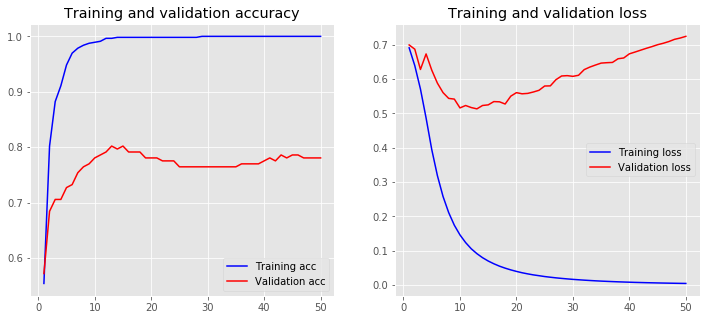

In [14]:
# applied on history object from keras
plot_history(history)

We can see clearly overfitting the train data. Too many epochs? In any case, there is a small improvement in accuracy over baseline model.

Next, let's experiment with different representation of the features. In particular, we look at word embeddings.

First, let's look at one-hot encoding: each word in a fixed vocabulary is represented by a vector of length n, where n is the cardianlity of the vocabulary. The vector contains only zeros, except for the index corresponding to the word in the vocabulary, whose value is set to one.

For example:

In [15]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London'] # an array of cities
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

We can use scikit-learn's LabelEncoder to convert categorical variable such a "cities" into categorical integer values

In [16]:
encoder = LabelEncoder() # initialize LabelEncoder
city_labels = encoder.fit_transform(cities) # apply to cities array
city_labels

array([1, 0, 0, 2, 1])

These labels can be used as input for scikit-learn's OneHotEncoder to obtain the vectors:

In [17]:
encoder = OneHotEncoder(sparse=False) # initialize OneHotEncoder
city_labels = city_labels.reshape((5, 1)) # resahpe vector
encoder.fit_transform(city_labels)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

To go back to our classification problem, Keras Tokenizer is a pre-processing method used to transform a sentence into a vector of integers, each of which corresponds to the position, in a fixed vocabulary, of the token found in that position in the sentence. Let us look at one example, while we apply this method to our full set of sentences:

In [18]:
 # we need to fix the vocab size from the beginning
tokenizer = Tokenizer(num_words=5000) # this will only consider only the 5000 most common tokens

tokenizer.fit_on_texts(sentences_train) # apply to our set of sentences

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

The indexing is based on the frequency in the vocabulary. For example:

In [23]:
for word in ['the', 'all', 'can', 'john']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
can: 77
john: 248


Let's look at one example of tokenized sentence:

In [24]:
print(sentences_train[2]) # the sentence
print(X_train[2]) # its vector

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


Clearly, sentences of different lengths will be associated with vectors of different lenghts. In order to avoid this, and have inputs of uniform lengths for a neural network, we can used Kera's method pad_sequences. Fixing a max sentence length n, this method converts all the vectors to vectors of lenght n, writing a zero in every empty position of each vector:

In [25]:
maxlen = 100 # specify max length of sentences beforehand

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :]) # for example

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


Notice that these hard hard-coded representations, not learned embeddings. These can be fed as input into a neural network which will learn the best embedding for a given task (in our case, classification). Typically, this will reduce the size of the vectors, obtaining so-called dense vectors (as opposed to sparse vectors full of zeros)

To do so, we use Kera's embedding layer:

In [26]:
model = Sequential() # initialize keras model

# add embedding layer
model.add(layers.Embedding(input_dim=vocab_size, # one input for each token in vocabulary
                           output_dim=50, # the size of the output learnt dense vectors
                           input_length=maxlen) # the size of the input hard-coded vectors
         )

model.add(layers.Flatten()) # flatten layer needed to adapt embedding layer output to dense layer input format

model.add(layers.Dense(10, activation='relu')) # as before, classifier neural network
model.add(layers.Dense(1, activation='sigmoid'))

Notice that the flatten layer is one possibility, but there are other ways to go which we'll explore later on.

In [27]:
# compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


Next, we train this model and take a look at loss and accuracy, as before:

Training Accuracy: 1.0000
Testing Accuracy:  0.6684


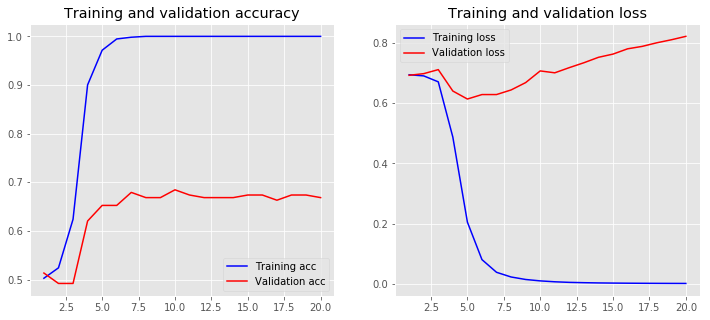

In [28]:
history = model.fit(X_train, y_train, # define training procedure
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

# print accuracy on train and test set
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot results over epochs
plot_history(history)

Not great. We mentioned the flatten layer was only one way to go. Let's experiment with others:

In [29]:
model = Sequential()

model.add(layers.Embedding(input_dim=vocab_size, # embedding layer as before
                           output_dim=50, 
                           input_length=maxlen)
         )
                           
model.add(layers.GlobalMaxPool1D()) # instead of flatten, this "downsamples" the input feature vectors

model.add(layers.Dense(10, activation='relu')) # classification as before
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training and results:

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Training Accuracy: 1.0000
Testing Accuracy:  0.7754


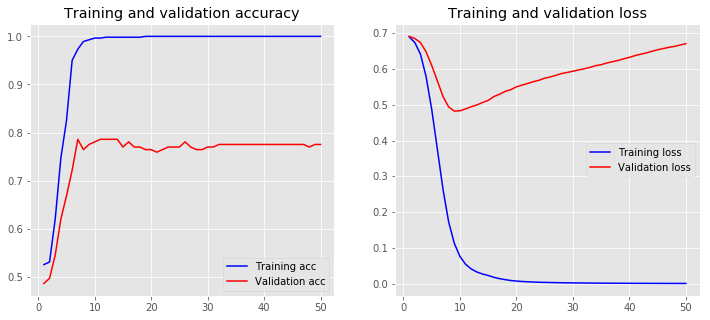

In [30]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

Better, but still overfitting training data.

When we talk about learned representations, another way to go is to used pre-trained word vectors, as opposed to defining a model which learns its own representations. The advantage is that pre-trained vectors available online have been typically trained on gigantic corpora with extremely fine-tuned procedures.

Pre-trained vectors include Word2Vec and GloVe among others. Here we used GloVe trained on 6 billion words corpus, availeble for free here: http://nlp.stanford.edu/data/glove.6B.zip 

First of all, we define a function which extract the trained vectors for the words which are actually present in our data set:

In [31]:
# input of the function: path to pre-trained vectors, word index, size of embedding
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

Apply this to our data set:

In [32]:
embedding_matrix = create_embedding_matrix(
    'data/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim=50
)

We can easily check how much of our vocabulary is covered by the pre-trained vectors:

In [33]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9522330097087378

Cool. Let's use these vectors in our classification model used above. In our first experiment we use the pre-trained vectors as they are, without allowing further learning on top of them:

In [34]:
# model
model = Sequential()
model.add(layers.Embedding(vocab_size,
                           output_dim=50, 
                           weights=[embedding_matrix], # notice this: embeddings provided externally
                           input_length=maxlen, 
                           trainable=False)
         )

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________


Training Accuracy: 0.7629
Testing Accuracy:  0.7273


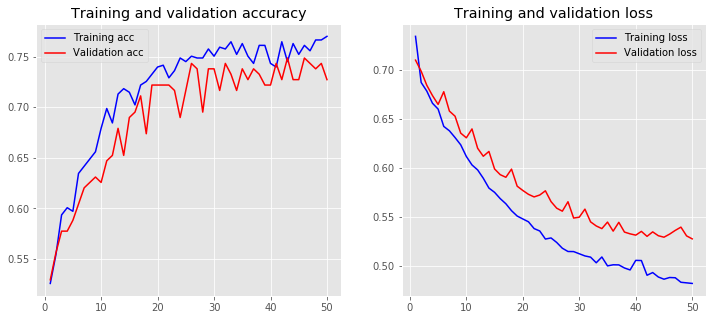

In [35]:
# train and results
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

Pretty bad. Let's see what happens if we allow our model to further learn representations on top of the pre-trained ones:

In [36]:
# model
model = Sequential()
model.add(layers.Embedding(vocab_size,
                           output_dim=50, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True) # notice this: vectors are further trainable
         )

model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8021


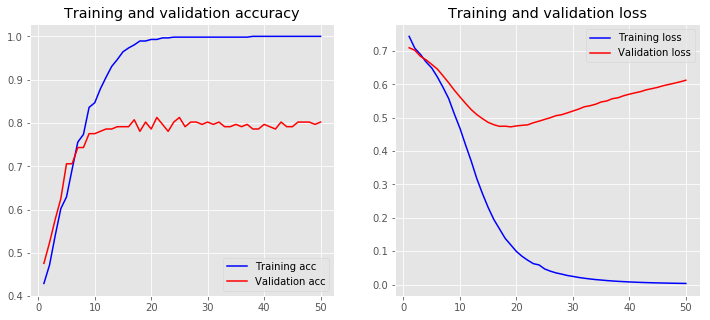

In [37]:
# train and results
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

Still no incredible improvements. 

Next, we try convolutional neural networks, which have been shown to perform well for text classification:

In [38]:
model = Sequential()

model.add(layers.Embedding(vocab_size,
                           output_dim=100, # now 100, not sure why...
                           input_length=maxlen)
         )

# convolutional layer
model.add(layers.Conv1D(128, # output of the filters size
                        5, # kernel size, the "window" moving around
                        activation='relu')
         )

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7647


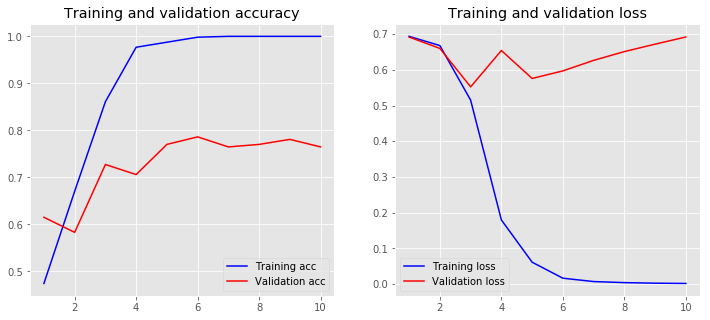

In [39]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

Ok, it seems hard to improve on accuracy of ~80%.

We might need to optimize hyperparameters.

We do so with reandom grid search, k-fold cross-validation, using KerasClassifier, a wrapper to use Keras models with scikit-learn's API.

KerasClassifier requires a function that creates a Keras model, which we define abstracting away from the parameters manually set in the definition of the CNN above, as follows:

In [40]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Next, we define a grid space of possible parameter values:

In [41]:
param_grid = dict(num_filters=[32, 64, 128], # these are choices
                  kernel_size=[3, 5, 7], # these are choices
                  vocab_size=[5000], # these are fixed
                  embedding_dim=[50],
                  maxlen=[100])

Finally, grid search is done as follows:

In [42]:
# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    # prompt = input(f"finished {source}; write to file and proceed? [y/n]")
    # if prompt.lower() not in {'y', 'true', 'yes'}:
    #    break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 11.1min finished


Running amazon data set
Best Accuracy : 0.8166
{'num_filters': 32, 'embedding_dim': 50, 'kernel_size': 5, 'maxlen': 100, 'vocab_size': 4603}
Test Accuracy : 0.8472


Running grid search for data set : imdb
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 12.6min finished


Running imdb data set
Best Accuracy : 0.8108
{'num_filters': 32, 'embedding_dim': 50, 'kernel_size': 3, 'maxlen': 100, 'vocab_size': 4603}
Test Accuracy : 0.8311


Running grid search for data set : yelp
Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 17.5min finished


Running yelp data set
Best Accuracy : 0.8137
{'num_filters': 32, 'embedding_dim': 50, 'kernel_size': 7, 'maxlen': 100, 'vocab_size': 4603}
Test Accuracy : 0.8341




Bellissimo!